# Exercise 6: Variational Monte Carlo simulation of a harmonic oscillator

**Goal:** Find the best approximation for the ground state energy and wave function of a one-dimensional quantum harmonic oscillator.

**Notes on the Variational Monte Carlo (VMC):**

We cannot solve the Schrödinger equation analytically for most systems. However, we know from the Variational Principle:
> The expectation value of the Hamiltonian calculated with *any* trial wave function $\Psi_T$ is always greater than or equal to the true ground state energy $E_0$.
> $$\langle E \rangle = \frac{\langle \Psi_T | \hat{H} | \Psi_T \rangle}{\langle \Psi_T | \Psi_T \rangle} \ge E_0$$

Our strategy to find the ground state will then be as follows:
1. We choose a trial function $\Psi_T(x; \alpha, \beta) = e^{-\alpha |x|^\beta}$ which depends on variatonal parameters $\alpha$ and $\beta$.
2. Given that we cannot integrate $\int |\Psi|^2 dx$ analytically, we use instead the Metropolis Algorithm to generate a chain of positions $\{x_1, x_2, ..., x_N\}$ distributed according to probability $P(x) \propto |\Psi_T(x)|^2$.
3. For every sampled position $x_i$, we calculate the "Local Energy":
   $$E_L(x) = \frac{\hat{H} \Psi_T(x)}{\Psi_T(x)}$$
   If $\Psi_T$ were the exact eigenstate, $E_L(x)$ would be a constant number everywhere. Since it's an approximation, $E_L(x)$ fluctuates.
4. The average of these local energies estimates $\langle E \rangle$.
5. We vary (optimize) $\alpha$ and $\beta$ to find the minimum average energy. The minimum we find is our best approximation of the ground state.

**Model**

The Hamiltonian of a single particle of mass m in a one-dimensional harmonic oscillator with frequency $\omega$ is given by

$$
\hat{H}=-\frac{\hbar^{2}}{2m}\frac{\partial^{2}}{\partial x^{2}}+\frac{1}{2}m\omega^{2}x^{2}
$$

The ground-state energy in a 1D oscillator is different from zero, $E_{0}=\hbar\omega/2$, due to quantum fluctuations, contrary to the classical case with zero minimal energy at $T=0$.

In the following, we will use dimensionless units and express all energies in units of $\hbar\omega$ and all distances in units of $r_{0}$ defined such that $\hbar^{2}/mr_{0}^{2}=m\omega^{2}r_{0}^{2}=\hbar\omega$.

The phase space is simple here as there is only one degree of freedom ($R=x$). Although integrals of a single variable can be conveniently calculated by deterministic methods, it is instructive to calculate them by means of Monte Carlo techniques.

We will choose the trial wave function in the following form

$$
\psi_{T}(x;\alpha,\beta)=exp(-\alpha|x|^{\beta}) \quad (2.1)
$$

where $\alpha>0$ and $\beta>1$ are variational parameters. The local energy contains two contributions, coming from the potential and kinetic energies,

1. potential energy $\frac{x^{2}}{2}$
2. kinetic energy, laplacian estimator:
   $$-\frac{1}{2}\frac{f_{1}^{\prime\prime}(x)}{f_{1}(x)}$$
3. kinetic energy, gradient estimator:
   $$+\frac{1}{2}\left(\frac{f_{1}^{\prime}(x)}{f_{1}(x)}\right)^{2}$$

here the one-body term is $f_{1}(x)=exp(-\alpha|x|^{\beta})$. Its logarithmic derivatives are: 

$$g_1(x)=f_{1}^{\prime}(x)/f_{1}(x)=-\alpha\beta|x|^{\beta-1}$$
$$g_2(x)=f_{1}^{\prime\prime}(x) /f_{1}(x)=-\alpha\beta(\beta-1)|x|^{\beta-2}+(\alpha\beta|x|^{\beta-1})^{2}$$

**Algorithm**

1. generate a random initial configuration
2. make a loop over Monte Carlo iterations
3. move the point $R\rightarrow R^{\prime}$ in the phase space. for example, each particle can be displaced according to a random flat $(r_{i}\rightarrow r_{i}+(2\xi-1)\Delta)$ or Gaussian $(r_{i}\rightarrow r_{i}+\xi)$ distribution
4. accept or reject the move according to the Metropolis algorithm. For example, throw a random number $\xi\in(0,1)$ and accept the move if $p(R^{\prime})/p(R)>\xi$.
5. accumulate the local energy and its square (energy: energy + local_energy; energy2 = energy2 + local_energy * local_energy); density profile;
6. after Niter iterations are done, estimate the mean energy $(\langle E\rangle\approx energy/Niter)$, its variance: $\sigma_{E}^{2}=\langle E^{2}-\langle E\rangle^{2}\rangle\approx$ energy2/Niter - (energy/Niter)**2 and its statistical error $\epsilon_{E}=\sigma_{E}/\sqrt{N_{uncorr}}$ where $N_{uncorr}$ is the number of uncorrelated measurements.

Note on the Metropolis algorithm: In order to make the code more numerically stable, instead of using the standard Metropolis acceptance condition $\text{Accept if } \frac{P_{new}}{P_{old}} > \xi$ (where $\xi$ is a random number between 0 and 1), we take the natural logarithm ($\ln$) of both sides: 

$$\ln\left(\frac{P_{new}}{P_{old}}\right) > \ln(\xi) \quad \Rightarrow \quad \ln(P_{new}) - \ln(P_{old}) > \ln(\xi),$$

where in this case $P = |\Psi|^2$.

**Tasks to be completed:**

1. fix variational parameter $\alpha$ to (a) $\alpha=1$ (b) $\alpha=1/2$ and explore how the variational energy depends on the second parameter $\beta$. Plot the obtained dependence of the energy.

2. Find the optimal value of $\beta$ for (a) $\alpha=1$ (b) $\alpha=1/2$ so that the variational energy is minimal for this value of $\beta$. Report the best variational result for the energy and its statistical error $(E\pm\epsilon)$ using two estimators for the kinetic energy. Show the density profile calculated for the optimal parameters.

3. Note that now the class of used functions contains the exact solution. How different is the behavior of the first and second estimators of the kinetic energy for the exact solution? What can be concluded about the variance?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [2]:
# HELPER FUNCTIONS

@njit
def local_energy(x, alpha, beta):
    """
    Computes the local energy coming from the two estimators (Laplacian & Gradient).
    """
    r = np.abs(x)

    # Avoid dividing by 0
    if r < 1e-10:
        return 0.0, 0.0

    # Potential energy
    V = 0.5 * r**2

    g1 = - alpha * beta * r**(beta - 1)
    g2 = - alpha * beta * (beta - 1) * r**(beta - 2) + g1**2
    
    # Kin Energy (Laplacian estimator)
    T_lap = -0.5 * g2
    # Kin Energy (Gradient estimator)
    T_grad = 0.5 * g1**2

    return T_lap + V, T_grad + V

@njit
def psi_T(x, alpha, beta):
    return np.exp(-alpha * np.abs(x)**beta)


# MC SIMULATION
@njit
def VMC_simulation(n_steps, alpha, beta, delta, x0=0.0):
    """
    Runs Variational Monte Carlo simulation with Metropolis algorithm.

    Inputs:
        n_steps             : number of MC steps to perform
        alpha, beta         : variational parameters for the trial wavefunction
        delta_max           : maximum displacement for trial moves
    Outputs:
        energies_lap        : energy history (Laplacian estimator)
        energies_grad       : energy history (Gradient estimator)
        acceptance_rate     : acceptance rate per step
        x_history           : history particle positions
    """
    # Storage for results
    energies_lap = np.zeros(n_steps)
    energies_grad = np.zeros(n_steps)
    x_history = np.zeros(n_steps)

    x = x0
    accepted = 0

    # Calculate current probability
    P_current = np.abs(psi_T(x, alpha, beta))**2

    # MC loop
    for step in range(n_steps):
        # 1. Propose a random move
        x_new = x + delta * (2.0 * np.random.rand() - 1.0)

        # 2. Compute new probability
        P_new = np.abs(psi_T(x_new, alpha, beta))**2

        # 3. Metropolis algorithm
        if (np.log(P_new) - np.log(P_current)) > np.log(np.random.rand()):
            x = x_new
            P_current = P_new
            accepted += 1
        
        # 4. Measure Local Energy
        e_lap, e_grad = local_energy(x, alpha, beta)
        
        energies_lap[step] = e_lap
        energies_grad[step] = e_grad
        x_history[step] = x
        
    return energies_lap, energies_grad, accepted / n_steps, x_history

We now fix $\alpha=0.5$ and $1$ and vary $\beta$ to see which optimal parameters minimize the energy.

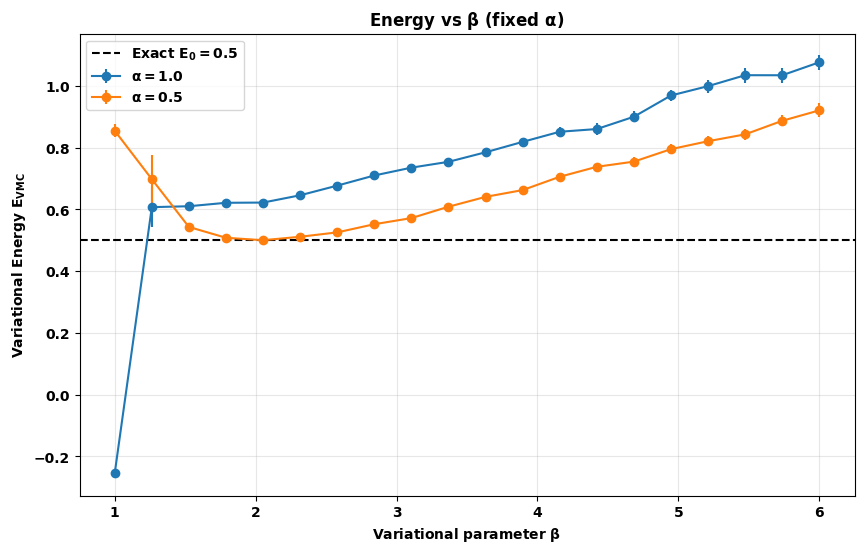

In [22]:
alphas = [1.0, 0.5]
beta_values = np.linspace(1.0, 6.0, 20) # Scan beta from 1 to 3
n_steps = 100000
delta = 2.0

plt.figure(figsize=(10, 6))

for alpha in alphas:
    energies = []
    errors = []
        
    for beta in beta_values:
        # Run simulation
        E_lap, _, acc, _ = VMC_simulation(n_steps, alpha, beta, delta)
        
        # Statistis
        # Note: We discard some initial steps (~10%) to allow the Markov chain 
        # to forget the arbitrary starting position and converge to the correct target probability distribution
        E_mean = np.mean(E_lap[int(n_steps*0.1):])
        
        # Error = std / sqrt(N)
        E_err = np.std(E_lap[int(n_steps*0.1):]) / np.sqrt(len(E_lap)*0.1) 
        
        energies.append(E_mean)
        errors.append(E_err)

    plt.errorbar(beta_values, energies, yerr=errors, marker='o', label=f'$\\alpha={alpha}$')

# Plot exact ground state energy (E0 = 0.5)
plt.axhline(0.5, color='k', linestyle='--', label='Exact $E_0=0.5$')

plt.xlabel(r'Variational parameter $\beta$')
plt.ylabel(r'Variational Energy $E_{VMC}$')
plt.title(r'Energy vs $\beta$ (fixed $\alpha$)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

According to the Variational Principle, the energy must always be $\ge 0.5$, so we discard the first energy point for $\alpha=1.0$.

On the other hand, we see from the plot that the variational parameters that minimize the energy are: $\alpha = 0.5$ and $\beta \approx 2$ (as expected theoretically). For these parameters, we compute the energy given by both the Laplacian and the Gradient estimators, along with their statistical errors. 

We also compare the density profile of our simulation to the well-known exact result: $|\Phi_0|^2 = e^{-x^2}$.

<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
C:\Users\jmarq\AppData\Local\Temp\ipykernel_36780\1905637864.py:27: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(x_grid, exact_density, 'r--', lw=2, label='Exact Density $|\phi_0|^2$')


Optimal Alpha: 0.5, Optimal Beta: 2.0
Energy (Laplacian Est): 0.500000 +/- 0.000000
Energy (Gradient Est):  0.497490 +/- 0.001053
Exact Energy: 0.5


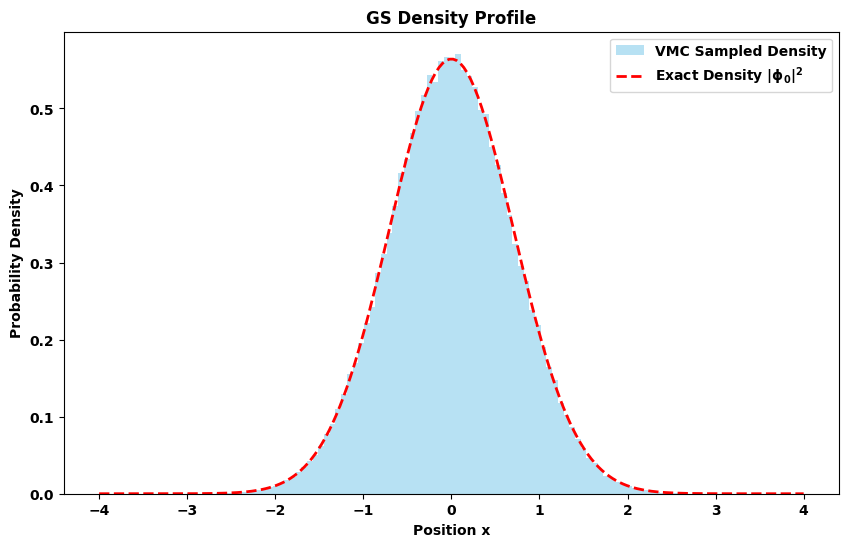

In [23]:
# Optimal parameters
opt_alpha = 0.5
opt_beta = 2.0 

# Run simulation
E_lap, E_grad, acc, x_hist = VMC_simulation(500000, opt_alpha, opt_beta, delta)

# Statistics
# As before, we discard the first ~10% results
E_lap = E_lap[50000:]
E_grad = E_grad[50000:]
x_hist = x_hist[50000:]

print(f"Optimal Alpha: {opt_alpha}, Optimal Beta: {opt_beta}")
print(f"Energy (Laplacian Est): {np.mean(E_lap):.6f} +/- {np.std(E_lap)/np.sqrt(len(E_lap)):.6f}")
print(f"Energy (Gradient Est):  {np.mean(E_grad):.6f} +/- {np.std(E_grad)/np.sqrt(len(E_grad)):.6f}")
print(f"Exact Energy: 0.5")

# Plot Density Profile
plt.figure(figsize=(10, 6))
plt.hist(x_hist, bins=100, density=True, alpha=0.6, color='skyblue', label='VMC Sampled Density')

# Compare with exact analytical density: 
#   psi_0 = exp(-0.5 * x^2) -> |psi|^2 = exp(-x^2)
x_grid = np.linspace(-4, 4, 200)
exact_density = np.exp(-x_grid**2) / np.sqrt(np.pi)
plt.plot(x_grid, exact_density, 'r--', lw=2, label='Exact Density $|\phi_0|^2$')

plt.xlabel('Position x')
plt.ylabel('Probability Density')
plt.title('GS Density Profile')
plt.legend()
plt.show()

Finally, let us study the behavior of the first and second estimators of the kinetic energy for the exact solution:

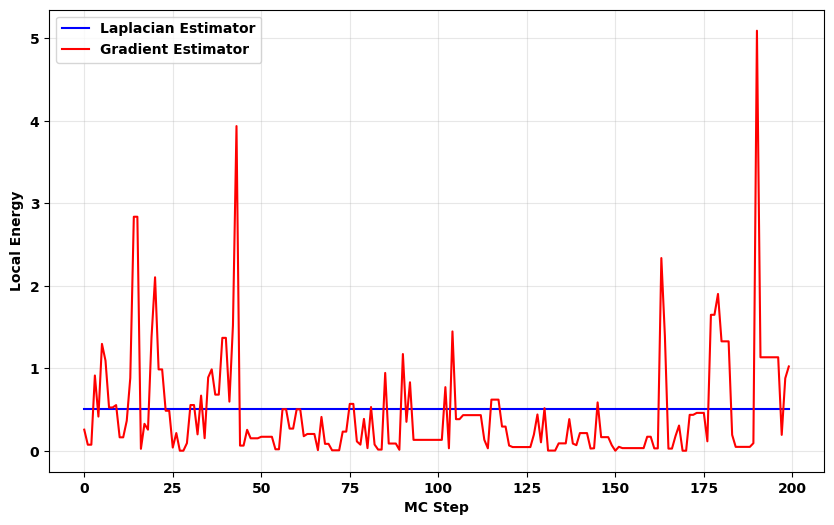

Variance of Laplacian Est: 0.0
Variance of Gradient Est:  0.49855185146034947


In [ ]:
# Let us plot a small slice of the simulation
slice_N = 200
steps = np.arange(slice_N)

plt.figure(figsize=(10, 6))
plt.plot(steps, E_lap[:slice_N], 'b-', label='Laplacian Estimator')
plt.plot(steps, E_grad[:slice_N], 'r-', label='Gradient Estimator')

plt.xlabel('MC Step')
plt.ylabel('Local Energy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Variance of Laplacian Est:", np.var(E_lap))
print("Variance of Gradient Est: ", np.var(E_grad))

From the plot, we see that the Laplacian estimator's energy is constant at $0.5$ (no variance) because we are evaluating an exact eigenstate (GS corresponding to $\alpha=0.5, \beta=2$) of the local energy opertor (which is indeed the Laplacian estimator). The Gradient estimator, however, is not the local energy operator, so it only gives the correct average but presents fluctuations.